# Three Body Problem

Three bodies orbit under the influence of gravity.  In general, the motion is chaotic and no practical closed form solution is known.  In practice the problem can be solved using numerical integrators.<br>
See https://en.wikipedia.org/wiki/Three-body_problem for a detailed discussion on the theory and history of this problem.

In [1]:
# Library imports
import tensorflow as tf
import rebound
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import plot_loss_hist, EpochLoss, TimeHistory
from tf_utils import Identity

from orbital_element import OrbitalElementToConfig, ConfigToOrbitalElement, MeanToTrueAnomaly, G_
from orbital_element import make_model_elt_to_cfg, make_model_cfg_to_elt

from jacobi import CartesianToJacobi, JacobiToCartesian

from g3b_data import make_traj_g3b, make_data_g3b, make_datasets_g3b, traj_to_batch
from g3b_data import make_datasets_solar, make_datasets_hard
from g3b_plot import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy, plot_orbit_element
from g3b import KineticEnergy_G3B, PotentialEnergy_G3B, Momentum_G3B, AngularMomentum_G3B
from g3b import VectorError, EnergyError
from g3b import Motion_G3B, make_physics_model_g3b
from g3b import compile_and_fit
from g3b_model_math import make_position_model_g3b_math, make_model_g3b_math
# from g3b_model_nn import make_position_model_g3b_nn, make_model_g3b_nn

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Lightweight serialization
fname = '../data/g3b/g3b.pickle'
vartbl = load_vartbl(fname)

### Orbital Elements Refresher

![title](../figs/web/orbital-elements.png)

**Variable Names of Six Keplerian Orbital Elements**
* `a` - semi-major axis; size of the ellipse; mean of periapsis and apoapsis distances
* `e` - eccentricity; shape of the ellipse.  e=0 is a circle, e=1 is a line.  $e^2 = 1 - b^2 / a^2$
* `inc` - inclination; angle between orbital and ecliptic planes
* `Omega` - longitude of the asending node; undefined when inc=0
* `omega` - argument of pericenter; true anomaly where body is closest to the primary.
* `f` - true anomaly; angle of the orbiting body in its orbital plane

**Two Additional Elements**
* `M` - mean anomaly; area swept out by the orbiting body, normalized so a full orbit is $2 \pi$.  Because of the rule of equal area in equal time, a.k.a. conservation of angular momentum, the mean anomly is linear in time
* `N` - mean motion; rate at which mean anomly changes, i.e. $2 \pi / T$ where $T$ is the orbital period

### Generate and Visualize One Example Orbital Path

The module `g3b_data.py` includes functions used to generate training data for the (general) three body problem.<br>
The function `make_traj_g3b` generates a single trajectory for the G3B problem.  It takes as inputs the masses of the three bodies, `m`; and the six traditional orbital elements (`a`, `e`, `inc`, `Omega`, `omega`, `f`).  The mass is an array of size 3, and each orbital element is an array of size 2.  Orbital elements describe the relationship between two bodies, or here the relationship between body i and the center of mass of bodies 0 through i-1.<br>
`make_traj_g3b` creates a new Rebound simulation with three particles: the sun and two orbiting bodies.  The sun has mass 1.0 in solar mass units, and initial position and velocity 0.<br>
The first orbiting body orbits around the primary (body 0, similar tot he sun) with initial position and velocity are assigned by Rebound based on the orbital elements.<br>
The second orbiting body orbits around the center of mass of body 0 and body 1.  In practice this will be very close to the primary.  This choice of coordinates is called Jacobi coordinates.<br>
The orbit is evaluated for a period of `n_years` with `sample_freq` observations per year.
Here I used 100 years and 10 observations per year, leading to 1001 data points counting both the start and end point.  The results are returned in two Dict objects named inputs and outputs.<br>
**Inputs**
* t - vector of times at which the orbit was sampled
* q0 - initial position of the bodies; shape (num_particles, space_dims,) = (3, 3,)
* v0 - initial velocity of the bodies; shape (num_particles, space_dims,) = (3, 3,)
* m - mass of the bodies in solar masses; shape (num_particles,) = (3,)

**Outputs**
* q - orbital positions of the bodies over time; shape (N, 3, 3,)
* v - orbital velocitiy of body 1 over time; shape (N, 3, 3,)
* a - orbital acceleration of body 1 over time;  shape (N, 3, 3,)
* q0_rec - recovered initial position of bodies; duplicate of q0_init
* v0_rec - recovered initial velocity of bodies; duplicate of v0_init
* T - the kinetic energy of the system; $T = \frac{1}{2} \sum_{i=1}^{3}{m_i |v_i|^2}$
* U - the potential energy of the system; 
$$U = \sum_{i=1}^{3}\sum_{j=i+1}^{3} \frac{-G m_i m_i}{r_{ij}}$$
where $r_{ij} = |qi - qj|$ is the distance between bodies $i$ and $j$
* H - the total energy in the system $H = T + U$
* P - the momentum, $P = \sum{m_i \cdot v_i}$
* L - the angular momentum, $L = \sum{q_i \times m_i v_i}$

In [5]:
# Generate one example trajectory with orbiting earth-like and jupiter-like planets
# https://ssd.jpl.nasa.gov/txt/p_elem_t1.txt
m = np.array([1.0, 1.0E-6, 1.0E-3])
a = np.array([1.00000, 5.2029])
e = np.array([0.0167, 0.0484])
inc = np.radians([0.00, 1.3044])
Omega = np.radians([0.00, 100.47])
omega = np.radians([102.94, 14.73]) - Omega
f = np.radians([100.46, 34.40]) - Omega
n_years = 100
sample_freq = 10

inputs_traj, outputs_traj = make_traj_g3b(m=m, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, 
                                          n_years=n_years, sample_freq=sample_freq)

# Combined dict
data_traj = {**inputs_traj, **outputs_traj}

# Review the fields
print('Input fields:', list(inputs_traj.keys()))
print('Output fields:', list(outputs_traj.keys()))

Input fields: ['t', 'q0', 'v0', 'm']
Output fields: ['q', 'v', 'a', 'orb_a', 'orb_e', 'orb_inc', 'orb_Omega', 'orb_omega', 'orb_f', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'P', 'L']


In [6]:
# Plot style 
plot_style()

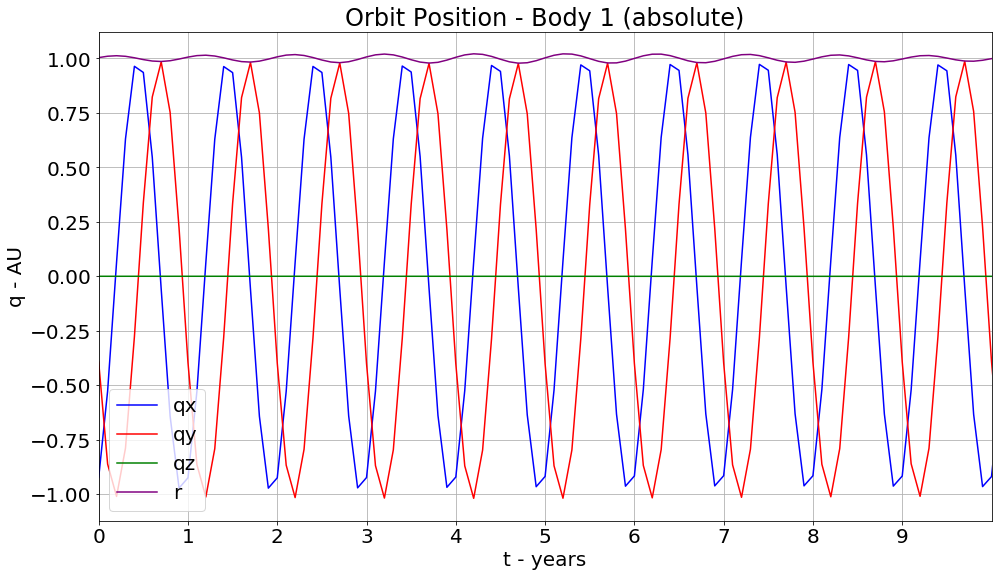

In [7]:
fig, ax = plot_orbit_q(data_traj, 1, False, 10.0)

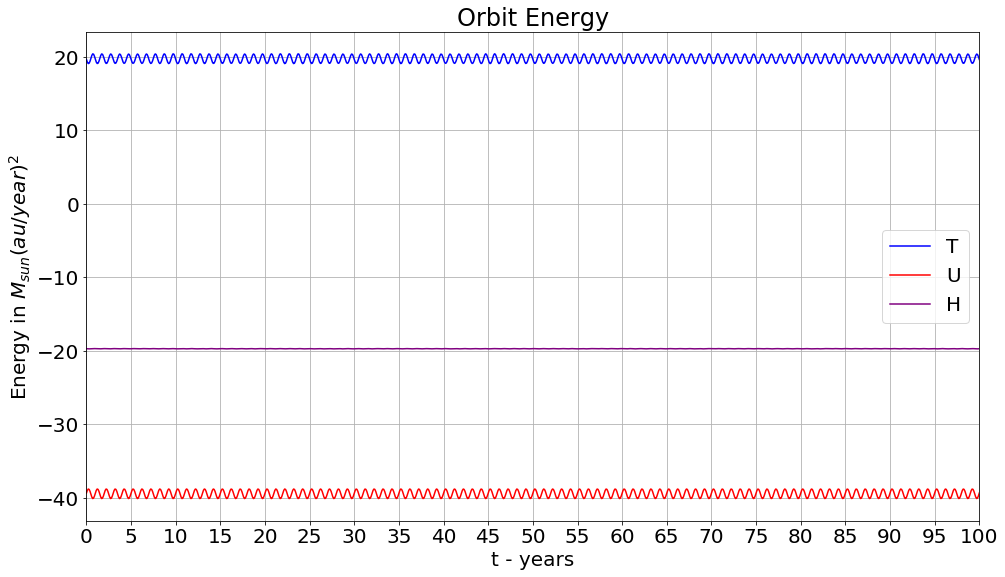

In [8]:
fig, ax = plot_orbit_energy(data_traj)

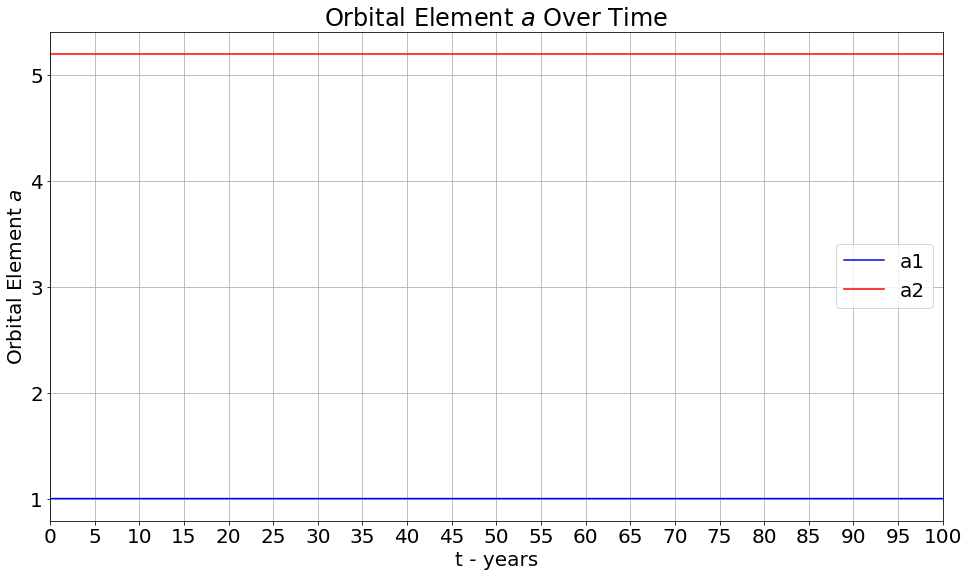

In [9]:
fig, ax = plot_orbit_element(data_traj, 'a')

In [10]:
# The eccentricity of body 1 has tiny wobbles that are barely visible
# fig, ax = plot_orbit_element(data_traj, 'e')

In [11]:
# fig, ax = plot_orbit_element(data_traj, 'inc')

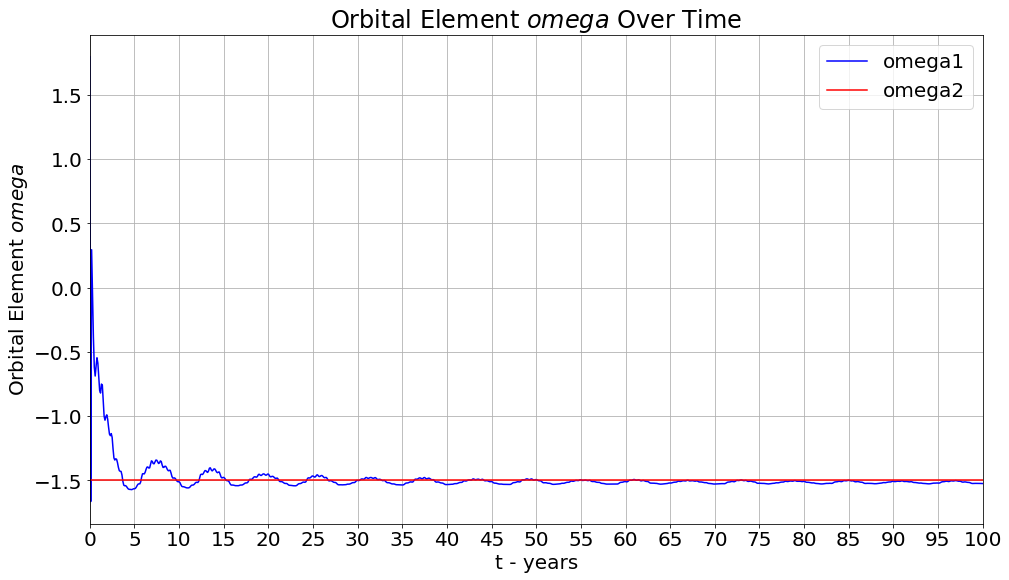

In [12]:
# The omega parameter for body 1 looks like a decaying sine curve; omega2 appears nearly constant.
fig, ax = plot_orbit_element(data_traj, 'omega')

In [13]:
# The true anomaly f looks like a staircase that is equivalent to a straight line mod two pi
# The wobbles comapred to the mean anomaly are not visible on this scale
# fig, ax = plot_orbit_element(data_traj, 'f')

### Generate Training Data with a Range of Orbital Parameters

The function `make_train_g3b` creates training data for the general 3 body problem in the form of dictionaries of numpy arrays.  These are analogous to the outputs of `make_traj_r3b`, but there is an outer index of `n_traj` different trajectories.  The inputs `m_min` and `m_max` control the mass range of bodies 2 and 3 solar units; the first body always has mass equal to 1 solar unit.<br>
The inputs `a_min`, `a_max`, `e_max`, and `inc_max` determine the sampling ranges for the parameters `a`, `e` and `inc` of the orbital elements of the starting configuration. <br>
The other orbital elements (`Omega`, `omega`, `f`) are sampled over the full range of admissible values.<br>
The function `make_datasets_r3b` generates three tensorflow Dataset objects for train, validation and test, respectively.  Data is generated in the form of Numpy arrays using `make_train_g3b` because it is easier to serialize in that format.  The function checks on disk to see if the data is already available, and if so, loads it.  Otherwise it generates and then saves it.  Effective serialization is critical because the data set is expensive to generate.

In [14]:
# Inputs for make_train_g3b
m_min = 1.0E-7
m_max = 2.0E-3
n_traj = 10
n_years = 100
sample_freq = 10
a_min = 0.50
a_max = 32.0
e_max = 0.08
inc_max = 0.04
seed = 42

In [15]:
# Test make_data_g3b
inputs, outputs= make_data_g3b(n_traj=n_traj, n_years=n_years, sample_freq=sample_freq,
                               a_min=a_min, a_max=a_max, e_max=e_max, inc_max=inc_max, seed=seed)

In [16]:
# Inputs for make_datasets_g3b
vt_split = 0.20
n_years = 100
sample_freq = 10

# The batch size
batch_size = 64

In [17]:
# Create a tiny data set with 100 solar type orbits
n_traj = 64
ds_tiny_trn, ds_tiny_val, ds_tiny_tst = make_datasets_solar(n_traj=n_traj, vt_split=0.0, 
                                                               n_years=n_years, sample_freq=sample_freq)

Unable to load data from ../data/g3b/881911622.pickle.


particle 1, m=5.300154824718853e-05, a=20.38086671891378, e=0.046862046501877065, inc=0.03604632041963956, Omega=-2.627885505319415, omega=-1.2479796227326374, f=2.8030261169836725
particle 0, m=0.001479832521494569, a=28.59946648807907, e=0.0021209048433297453, inc=0.02337257247692401, Omega=0.8036218480318178, omega=-0.23448982234152194, f=2.2731660983009743
Status before shift to COM:
---------------------------------
REBOUND version:     	3.8.3
REBOUND built on:    	Jun  6 2019 12:14:12
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.100000
---------------------------------
<rebound.Particle object, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.Particle object, m=5.300154824718853e-05 x=10.155578515826209 y=-18.680709720148222 z=0.7666809344255396 vx=1.1803472851306693 vy=0.6170471079457281 vz=0.0015373035503336724>
<rebound.Particle object, m=0.001479832521494569 x=-27.359877890729038 y=8.43813911154

W0815 16:44:51.815929 139877655529280 deprecation.py:323] From /home/michael/anaconda3/envs/nbody/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
# Create a medium data set with 10,000 solar type orbits
n_traj = 10000

ds_small_trn, ds_small_val, ds_small_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, 
                                                               n_years=n_years, sample_freq=sample_freq)

Unable to load data from ../data/g3b/398004947.pickle.


KeyboardInterrupt: 

In [ ]:
# Create a large data set with 50,000 solar type orbits
n_traj = 50000

ds_large_trn, ds_large_val, ds_large_tst = make_datasets_solar(n_traj=n_traj, vt_split=vt_split, 
                                                               n_years=n_years, sample_freq=sample_freq)

***Generating 14,000 trajectories takes about 52 minutes on my server and uses about 2.68 GB of disk space.***<br>
***Generating 70,000 trajectories takes about 265 minutes (4:25) and uses about 13.42 GB of disk space***<br>
Pace is about 4.5 trajectories per second. Storage requirements about 145 KB / trajectory.<br>

### Review One Example Batch of Training Data

In [19]:
# Example batch
# batch_in, batch_out = list(ds_small_trn.take(1))[0]
batch_in, batch_out = list(ds_tiny_trn.take(1))[0]
batch_tiny_in, batch_tiny_out = batch_in, batch_out
print('Input field names: ', list(batch_in.keys()))
print('Output field names:', list(batch_out.keys()))
# inputs
t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
m = batch_in['m']
# outputs - trajectory
q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
# outputs - orbital elements
orb_a = batch_out['orb_a']
orb_e = batch_out['orb_e']
orb_inc = batch_out['orb_inc']
orb_Omega = batch_out['orb_Omega']
orb_omega = batch_out['orb_omega']
orb_f = batch_out['orb_f']
# outputs - physics
H = batch_out['H']
P = batch_out['P']
L = batch_out['L']

print(f'\nExample batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'm  = {m.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'P  = {P.shape}')
print(f'L  = {L.shape}')

Input field names:  ['t', 'q0', 'v0', 'm']
Output field names: ['q', 'v', 'a', 'orb_a', 'orb_e', 'orb_inc', 'orb_Omega', 'orb_omega', 'orb_f', 'q0_rec', 'v0_rec', 'T', 'U', 'H', 'P', 'L']

Example batch sizes:
t  = (64, 1001)
q0 = (64, 3, 3)
v0 = (64, 3, 3)
m  = (64, 3)
q  = (64, 1001, 3, 3)
v  = (64, 1001, 3, 3)
a  = (64, 1001, 3, 3)
H  = (64, 1001)
P  = (64, 1001, 3)
L  = (64, 1001, 3)


### Custom Keras Layers with Physics Computations of Energy and Angular Momentum

The module `g3b.py` contains shared elements used in the general 3 body problem.<br>
The layer `KineticEnergy_G3B` computes the kinetic energy of the system given the object masses `m` with shape (3,) and the velocities `v` with shape (traj_size, 3, 3).<br>
The kinetetic energy is $T = \frac{1}{2} \sum m_i |v_i|^2$ <br>
The layer `PotentialEnergy_G3B` computes the potential energy of the system given the masses `m` and the positions `q` with shape (traj_size, 3, 3).  <br>
The potential energy 
$$U = -\sum_{i<j}{\frac{G m_i m_j}{r_{ij}}}$$ 
where $r_{ij} = |q_j - q_i|$. For the 3 body problem there are ${3}\choose{2} = 3$ interaction pairs.<br>
The layer `Momentum_G3B` computes the momentum of the system given its masses `m`, and velocity `v`. This quantity will be constant by conservation of momentum.  In the center of momentum frame adopted by convention, both the momentum and center of mass will be the zero vector.<br>
The momentum $P = \sum m_i v_i$<br>
The layer `AngularMomentum_G3B` computes the angular momentum of the system given its masses `m`, position `q` and velocity `v`.<br>
The angular momentum $L = \sum q_i \times m_i v_i$, the 3D vector cross product.

In addition to the custom layers computing the physical quantities, there are also custom loss functions intended to be used with them.<br>
The custom loss function `VectorError` returns the relative error 
$$E = \frac{|y_{true} - y_{pred}|}{|y_{true}| + R}$$
where $R$ is an optional regularization term that defaults to 0.<br>
The custom loss function `EnergyError` returns a log scaled squared error
$$E = \log{\left[1 + \left(\frac{y_{pred} - y_{true}}{y_{true}}\right)^2\right]}$$
The log scaling is introduced so that the error doesn't blow up catastrophically when distance gets too small.  This was causing problems in training when an un-scaled energy error was used.

**Call layers with physics computations**

In [20]:
T = KineticEnergy_G3B()([m, v])
T.shape

TensorShape([64, 1001])

In [21]:
U = PotentialEnergy_G3B()([m, q])
U.shape

TensorShape([64, 1001])

In [22]:
P = Momentum_G3B()([m, v])
P.shape

TensorShape([64, 1001, 3])

In [23]:
L = AngularMomentum_G3B()([m, q, v])
L.shape

TensorShape([64, 1001, 3])

## Convert Initial Configuration from Cartesian to Jacobi Coordinates

In [24]:
# Compute the Jacobi coordinates of the initial conditions
qj0, vj0, mu0 = CartesianToJacobi()([m, q0, v0])

In [25]:
# Review shape of Jacobi inputs
print(f'Shape of q0 : {q0.shape}')
print(f'Shape of v0:  {v0.shape}')
print(f'Shape of m:   {m.shape}')

# Review shape of Jacobi outputs
print(f'Shape of qj0: {qj0.shape}')
print(f'Shape of vj0: {vj0.shape}')
print(f'Shape of mu0: {mu0.shape}')

Shape of q0 : (64, 3, 3)
Shape of v0:  (64, 3, 3)
Shape of m:   (64, 3)
Shape of qj0: (64, 3, 3)
Shape of vj0: (64, 3, 3)
Shape of mu0: (64, 3)


In [26]:
# qj0[0]

In [27]:
# vj0[0]

In [28]:
# Check that the round trip back to Cartesian coordinates is consistent
q0_rec, v0_rec = JacobiToCartesian()([m, qj0, vj0])

# Compute errors
rms = lambda x : np.sqrt(np.mean(np.square(x)))

err_q0 = q0_rec - q0
err_v0 = v0_rec - v0
rms_q0 = rms(err_q0)
rms_v0 = rms(err_v0)

# Display errors
print(f'RMS Error in q0_rec: {rms_q0:5.3e}')
print(f'RMS Error in v0_rec: {rms_v0:5.3e}')

RMS Error in q0_rec: 4.772e-07
RMS Error in v0_rec: 5.319e-08


***The round trip between Jacobi to Cartesian coordinates is very accurate***

## Convert Jacobi Coordinates to Orbital Elements

In [29]:
# Extract Jacobi coordinates of p1 and p2

# Initial position qj0
qj0_1 = qj0[:, 1, :]
vj0_1 = vj0[:, 1, :]

# Initial velocity qv0
qj0_2 = qj0[:, 2, :]
vj0_2 = vj0[:, 2, :]

# Gravitational field strength for orbital element conversion of p1 and p2
mu0_1 = mu0[:, 1:2]
mu0_2 = mu0[:, 2:3]

In [30]:
# Tuple of inputs for the model converting from configuration to orbital elements
cfg_1 = (qj0_1, vj0_1, mu0_1)
cfg_2 = (qj0_2, vj0_2, mu0_2)

In [31]:
# Model mapping cartesian coordinates to orbital elements
model_c2e = make_model_cfg_to_elt()

In [32]:
# Extract the orbital elements of the initial conditions
a1_0, e1_0, inc1_0, Omega1_0, omega1_0, f1_0, M1_0, N1_0 = model_c2e(cfg_1)
a2_0, e2_0, inc2_0, Omega2_0, omega2_0, f2_0, M2_0, N2_0 = model_c2e(cfg_2)

**Position Model: Compute q over time with Orbital Elements and Kepler's Equation**<br>
In the next section, we instantiate a mathematical position model.

In [33]:
n_years = 100
sample_freq = 10
traj_size = n_years * sample_freq + 1
batch_size = 64

In [34]:
position_model_math = make_position_model_g3b_math(traj_size=traj_size, batch_size=batch_size)

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss_pos = {'q': VectorError(name='q_loss'),
            'v': VectorError(name='v_loss'),}

metrics = None

loss_weights_pos = {'q': 1.0,
                    'v': 1.0,}

In [36]:
position_model_math.compile(optimizer=optimizer, loss=loss_pos, metrics=metrics, loss_weights=loss_weights_pos)

In [37]:
# Test the position model on the tiny data set
position_model_math.evaluate(ds_tiny_trn)

1/1 [==============================] - 1s 1s/step - loss: 0.0143 - q_loss: 0.0094 - v_loss: 0.0049


[0.014345470815896988, 0.009423045, 0.004922426]

In [ ]:
# Test the position model on the example batch; 
# b/c the tiny set has 100 elements it only has 1 batch when dropping remainders
# so the output should be the same as with evaluate(ds_tiny_trn)
position_model_math.test_on_batch(batch_in, batch_out)

In [ ]:
# Test the position model on the small data set
# position_model_math.evaluate(ds_small_trn)

In [ ]:
q_pos, v_pos = position_model_math([t, q0, v0, m])
print('shape of position_model outputs:')
print(f'q_pos: {q_pos.shape}')
print(f'v_pos: {v_pos.shape}')

In [ ]:
# position_model_math({'t':t, 'q0':q0, 'v0':v0, 'm':m})
# position_model_math([batch_tiny_in['t'], batch_tiny_in['q0'], batch_tiny_in['v0'], batch_tiny_in['m'])

In [ ]:
# Compute RMS error in recovered position
num_body=3
q_err = q_pos - q
q_rms_err = rms(q_err)
q_rel_err = q_err / np.reshape(np.linalg.norm(q, axis=-1), (batch_size, traj_size, num_body, 1))
q_rms_rel_err = rms(q_rel_err)
print(f'Position RMS error: {q_rms_err:5.2e}')
# print(f'Position RMS relative error:{q_rms_rel_err:5.2e}')

In [ ]:
# Compute RMS error in recovered initial position; should be nearly zero
q0_err = np.linalg.norm(q_err[:,0,:,:], axis=(1,2,))
# Index with max error
idx = np.argmax(q0_err)

# Print error
print(f'RMS Error in q0: {rms(q0_err):5.2e}')
print(f'Max error at index {idx} = {q0_err[idx]:9.6f}')
q0_err

In [ ]:
# Print initial orbital elements with worst error
print(f'Initial orbital elements')
print('m:    ', m[idx].numpy())
print('a:    ', orb_a[idx, 0].numpy())
print('e:    ', orb_e[idx, 0].numpy())
print('inc:  ', orb_inc[idx, 0].numpy())
print('Omega:', orb_Omega[idx, 0].numpy())
print('omega:', orb_omega[idx, 0].numpy())
print('f:    ', orb_f[idx, 0].numpy())

**Motion Model: Compute v and a from q using automatic differentiation**<br>
In the next section, we instantiate a motion model using mathematical position model.

In [ ]:
motion_model_math = Motion_G3B(position_model=position_model_math, name='motion_model')

In [ ]:
q_mot, v_mot, a_mot = motion_model_math([t, q0, v0, m])
print('shape of motion_model outputs:')
print(f'q_mot: {q_mot.shape}')
print(f'v_mot: {v_mot.shape}')
print(f'a_mot: {a_mot.shape}')

In [ ]:
# Compare v_mot with v_pos
vel_err = v_mot - v_pos

# Compute RMS error
v_rms_err = np.sqrt(np.mean(vel_err**2))
v_rel_err = v_rms_err / np.sqrt(np.mean(v_pos**2))
print(f'RMS error of recovered velocity from automatic differentiation vs. orbital elements:')
print(f'{v_rms_err:5.2E}')
print(f'Relative error of recovered velocity from automatic differentiation vs. orbital elements:')
print(f'{v_rel_err:5.2E}')

**Full physics model: computes energy, momentum and angular momentum from m, q, v**<br>
In the next section, we instantiate a full physics model from the same mathematical position model.<br>
This model is evloving the G3B system using Kepler's Equation and computing the physical quantities.
It is an approximate solution only that treats the 3 body system as two 2 body systems described in Jacobi coordinates.
Body 1 orbits around the primary in the first system.  Body 2 orbits around the center of mass of body 1 in the second system.  The second system is simplified by replacing the primary and body 1 with their combined center of mass.

In [ ]:
# model_math = make_physics_model_g3b(position_model=position_model_math, traj_size=traj_size)

In [ ]:
model_math = make_model_g3b_math(traj_size=traj_size)

## Review outputs of math model

In [ ]:
q, v, a, q0_rec, v0_rec, H, P, L = model_math([t, q0, v0, m])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'P = {P.shape}')
print(f'L = {L.shape}')

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss = {'q': VectorError(name='q_loss'),
        'v': VectorError(name='v_loss'),
        'a': VectorError(regularizer=1.0, name='a_loss'),
        'q0_rec': VectorError(name='q0_loss'),
        'v0_rec': VectorError(name='v0_loss'),
        'H': EnergyError(name='H_loss'),
        'P': VectorError(name='P_loss', regularizer=1.0),
        'L': VectorError(name='L_loss'),
       }

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'P': 1.0,
                'L': 1.0}

In [ ]:
# Compile the mathematical model
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the math model on the small data set
model_math.evaluate(ds_small_trn)

### Debug Position Model Code
Why is doesn't recovered q0 and v0 match the initial conditions?

In [ ]:
# Data for sol, earth, jupiter 3 body problem
m = np.array([1.0, 1.0E-6, 1.0E-3])
# m = np.array([1.0, 1.0E-2, 1.0E-2])
# m = np.array([1.0, 1.0E-6, 1.0E-6])
a = np.array([1.00000, 5.2029])
e = np.array([0.0167, 0.0484])
# inc = np.radians([0.0000, 1.3044])
inc = np.radians([0.0001, 1.3044])
Omega = np.radians([0.00, 100.47])
omega = np.radians([102.94, 14.73]) - Omega
f = np.radians([100.46, 34.40]) - Omega
n_years = 100
sample_freq = 10

In [ ]:
# Create a tiny data set with 64 solar type orbits
n_traj = 64
ds_tiny_trn, ds_tiny_val, ds_tiny_tst = make_datasets_solar(n_traj=n_traj, vt_split=0.0, 
                                                               n_years=n_years, sample_freq=sample_freq)

In [ ]:
batch_tiny_in, batch_tiny_out = list(ds_tiny_trn.take(1))[0]

In [ ]:
position_model_math.test_on_batch(batch_tiny_in, batch_tiny_out)

In [ ]:
q_pos, v_pos = position_model_math([batch_tiny_in['t'], batch_tiny_in['q0'], batch_tiny_in['v0'], batch_tiny_in['m']])

In [ ]:
q_err = q_pos - batch_tiny_out['q']

In [ ]:
rms = lambda x : np.sqrt(np.mean(np.square(x)))

In [ ]:
# Compute RMS error in recovered initial position; should be nearly zero
q0_err = np.linalg.norm(q_err[:,0,:,:], axis=(1,2,))
# Index with max error
idx = np.argmax(q0_err)

# Print error
print(f'RMS Error in q0: {rms(q0_err):5.2e}')
print(f'Max error at index {idx} = {q0_err[idx]:9.6f}')
q0_err

In [ ]:
# import pickle

# filename = '../data/g3b/881911622.pickle'
# with open(filename, 'rb') as fh:
#     vartbl_ = pickle.load(fh)
#     inputs_trn = vartbl_['inputs_trn']
#     outputs_trn = vartbl_['outputs_trn']
#     inputs_val = vartbl_['inputs_val']
#     outputs_val = vartbl_['outputs_val']
#     inputs_tst = vartbl_['inputs_tst']
#     outputs_tst = vartbl_['outputs_tst']
#     print(f'Loaded data from {filename}.')
#     # data  = (inputs_trn, outputs_trn, inputs_val, outputs_val, inputs_tst, outputs_tst)
    
# batch_tiny_in, batch_tiny_out = inputs_trn, outputs_trn

In [ ]:
# Data for 3 body problem with highest error in tiny batch
m = batch_tiny_in['m'][idx]
a = batch_tiny_out['orb_a'][idx,0]
e = batch_tiny_out['orb_e'][idx,0]
inc = batch_tiny_out['orb_inc'][idx,0]
Omega = batch_tiny_out['orb_Omega'][idx,0]
omega = batch_tiny_out['orb_omega'][idx,0]
f = batch_tiny_out['orb_f'][idx,0]
integrator = 'ias15'

In [ ]:
# One trajectory
inputs_traj, outputs_traj = make_traj_g3b(m=m, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f, 
                                          n_years=n_years, sample_freq=sample_freq, integrator=integrator)

# Batch with clones of this system
batch_in, batch_out = traj_to_batch(inputs_traj, outputs_traj, batch_size)

In [ ]:
# Expected values
orb_in_a0 = a
orb_in_e0 = e
orb_in_inc0 = inc
orb_in_Omega0 = Omega
orb_in_omega0 = omega
orb_in_f0 = f

# print(f'Input orbital elements for earth and jupiter:')
print(f'Input orbital elements for test system with idx={idx}:')
print(f'm    = [{m[1]:10.8e}, {m[2]:10.8e}]')
print(f'a    = [{a[0]: 8.6f}, {a[1]: 8.6f}]')
print(f'e    = [{e[0]: 8.6f}, {e[1]: 8.6f}]')
print(f'inc  = [{inc[0]: 8.6f}, {inc[1]: 8.6f}]')
print(f'Omega= [{Omega[0]:+8.6f}, {Omega[1]:+8.6f}]')
print(f'omega= [{omega[0]:+8.6f}, {omega[1]:+8.6f}]')
print(f'f    = [{f[0]:+8.6f}, {f[1]:+8.6f}]')

In [ ]:
position_model_math.test_on_batch(batch_tiny_in, batch_tiny_out)

In [ ]:
position_model_math.test_on_batch(batch_in, batch_out)

**Why is error on [batch_in, batch_out] smaller than [batch_tiny_in, batch_tiny_out]?**<br>
batch_ is supposed to be 64 copies of the row with the largest error in batch_tiny_.  The error should be larger...<br>
Compare contents of the arrays to see what's going on.

In [ ]:
print(f'Norm of difference between batch_tiny_in and batch_in')
for var in ['t', 'q0', 'v0', 'm']:
    diff = np.linalg.norm(batch_in[var][idx] - batch_tiny_in[var][idx])
    print(f'{var:5}: {diff:5.3e}')

In [ ]:
print(f'Norm of difference between batch_tiny_out and batch_out')
for var in ['q', 'v']:
    diff = np.linalg.norm(batch_out[var][idx] - batch_tiny_out[var][idx])
    print(f'{var:5}: {diff:5.3e}')

In [ ]:
diff = (batch_in['m'][idx] - batch_tiny_in['m'][idx].numpy())
print(f'm:')
print('batch_in     \n', batch_in['m'][idx])
print('batch_tiny_in\n', batch_tiny_in['m'][idx].numpy())
print('diff\n', diff)

In [ ]:
diff = (batch_in['q0'][idx] - batch_tiny_in['q0'][idx].numpy())
print(f'q0:')
print('batch_in     \n', batch_in['q0'][idx])
print('batch_tiny_in\n', batch_tiny_in['q0'][idx].numpy())
print('diff\n', diff)

In [ ]:
# batch_in['q0'][0]

In [ ]:
# batch_tiny_in['q0'][idx]

In [ ]:
# batch_tiny_in['q0'][idx] - batch_in['q0'][0]

**Check center of mass by hand**

In [ ]:
batch_in['q0'][0,:,0] * batch_in['m'][0]

In [ ]:
np.sum(batch_in['q0'][0,:,0] * batch_in['m'][0])

In [ ]:
(batch_tiny_in['q0'][idx,:,0] * batch_tiny_in['m'][idx])

In [ ]:
np.sum(batch_tiny_in['q0'][idx,:,0] * batch_tiny_in['m'][idx])

Check that orbital elements match:

In [ ]:
batch_tiny_out['orb_a'][idx,0] - batch_out['orb_a'][0,0]

In [ ]:
batch_tiny_out['orb_e'][idx,0] - batch_out['orb_e'][0,0]

In [ ]:
batch_tiny_out['orb_inc'][idx,0] - batch_out['orb_inc'][0,0]

In [ ]:
batch_tiny_out['orb_Omega'][idx,0] - batch_out['orb_Omega'][0,0]

In [ ]:
batch_tiny_out['orb_omega'][idx,0] - batch_out['orb_omega'][0,0]

In [ ]:
batch_tiny_out['orb_f'][idx,0] - batch_out['orb_f'][0,0]

**Compare Output Trajectories**

In [ ]:
j=0
norm_q0 = np.linalg.norm(batch_tiny_out['q'][idx] - batch_out['q'][idx])
print(f'{norm_q0:5.2e}')
print(batch_tiny_out['q'][idx,j] - batch_out['q'][idx,j])

In [ ]:
j=100
norm_v0 = np.linalg.norm(batch_tiny_out['v'][idx] - batch_out['v'][idx])
print(f'{norm_v0:5.2e}')
print(batch_tiny_out['v'][idx,j] - batch_out['v'][idx,j])

**Live call to make_data_g3b**

In [ ]:
batch_2_in, batch_2_out = make_data_g3b(n_traj=64, n_years=n_years, sample_freq=sample_freq, 
                                        m_min=1.0E-7, m_max=2.0E-3, a_min=0.50, a_max=32.0, e_max=0.20, inc_max=0.04, seed=42)

In [ ]:
batch_2_in['m'][0]

In [ ]:
batch_2_in['q0'][idx]

In [ ]:
batch_2_in['q0'][0,:,0] * batch_2_in['m'][0]

In [ ]:
np.sum(batch_2_in['q0'][0,:,0] * batch_2_in['m'][0])

In [ ]:
# Alias to arrays in batches
t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
m = batch_in['m']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
P = batch_out['P']
L = batch_out['L']

In [ ]:
# Alias arrays with model outputs
q_out, v_out = position_model_math([t, q0, v0, m])

In [ ]:
# q0[0]

In [ ]:
# q_out[0, 0]

In [ ]:
q0_err = q_out[0, 0] - q0[0]
print(f'Error in q0: rms = {rms(q0_err):5.2e}')
print(q0_err.numpy())

In [ ]:
v0_err = v_out[0, 0] - v0[0]
print(f'Error in v0: rms = {rms(v0_err):5.2e}')
print(v0_err.numpy())

**The initial position q0 and velocity v0 are recovered to order 1E-7**

In [ ]:
q_err = q_out[0] - q[0]
q_err_ts = np.linalg.norm(q_err, axis=(1,2,))
q_err_mean = np.linalg.norm(q_err)/traj_size
print(f'RMS position error: {q_err_mean:5.2e}')
print('Time series of errors in q:')
for x in q_err_ts[0:101:10]:
    print(f'{x:5.2e}', end=', ')

In [ ]:
v_err = v_out[0] - v[0]
v_err_ts = np.linalg.norm(v_err, axis=(1,2,))
v_err_mean = np.linalg.norm(v_err)/traj_size
print(f'RMS velocity error: {v_err_mean:5.2e}')
print('Time series of errors in v:')
for x in v_err_ts[0:101:10]:
    print(f'{x:5.2e}', end=', ')

**Summary of Accuracy for earth-jupiter type systems as masses vary:**<br>
When the mass is small (e.g. 1E-6 on both planets), 100 years of simulations is very accurate.<br>
Mean position error is 1.78E-6; accuracy trend is 5.6E-7 to 1.2E-5.<br>
When the mass is large (e.g. 1E-2 on both planets), 100 years of simulations have declining accuracy, but are still quite close. <br>
Mean position error is 4.15E-3; accuracy trend is 7.2E-7 to 2.5E-2.<br>
With approximate solar system values (1E-3, 1E-6), 100 years of simulation are a good approximation.<br>
Mean position error is 2.53E-4; accuracy trend 1.23E-6 to 1.42E-3.

### Deep dive into position model

In [ ]:
batch_size=64
space_dims=3

# Wrap these up into one tuple of inputs for the model
inputs = (t, q0, v0, m)

# Compute the Jacobi coordinates of the initial conditions
qj0, vj0, mu0 = CartesianToJacobi()([m, q0, v0])

# Extract Jacobi coordinates of p1 and p2
qj0_1 = qj0[:, 1, :]
qj0_2 = qj0[:, 2, :]
vj0_1 = vj0[:, 1, :]
vj0_2 = vj0[:, 2, :]

# Extract gravitational field strength for orbital element conversion of p1 and p2
mu0_1 = mu0[:, 1:2]
mu0_2 = mu0[:, 2:3]

# Manually set the shapes to work around documented bug on slices losing shape info
jacobi_shape = (batch_size, space_dims)
qj0_1.set_shape(jacobi_shape)
qj0_2.set_shape(jacobi_shape)
vj0_1.set_shape(jacobi_shape)
vj0_1.set_shape(jacobi_shape)
mu_shape = (batch_size, 1)
mu0_1.set_shape(mu_shape)
mu0_2.set_shape(mu_shape)

# Tuple of inputs for the model converting from configuration to orbital elements
cfg_1 = (qj0_1, vj0_1, mu0_1)
cfg_2 = (qj0_2, vj0_2, mu0_2)

# Print initial configuration
print(f'Initial Configuration (Jacobi coordinates)')
print(f'qj0_1 = {qj0_1[0]}')
print(f'vj0_1 = {vj0_1[0]}')

# Model mapping cartesian coordinates to orbital elements
# model_c2e = make_model_cfg_to_elt()
model_c2e_1 = make_model_cfg_to_elt()
model_c2e_2 = make_model_cfg_to_elt()

# Extract the orbital elements of the initial conditions
a1_0, e1_0, inc1_0, Omega1_0, omega1_0, f1_0, M1_0, N1_0 = model_c2e_1(cfg_1)
a2_0, e2_0, inc2_0, Omega2_0, omega2_0, f2_0, M2_0, N2_0 = model_c2e_2(cfg_2)

# Extract the orbital elements of the initial conditions
a1_0, e1_0, inc1_0, Omega1_0, omega1_0, f1_0, M1_0, N1_0 = model_c2e(cfg_1)
a2_0, e2_0, inc2_0, Omega2_0, omega2_0, f2_0, M2_0, N2_0 = model_c2e(cfg_2)

# Assemble initial orbital elements
orb_a0 = np.hstack([a1_0, a2_0])
orb_e0 = np.hstack([e1_0, e2_0])
orb_inc0 = np.hstack([inc1_0, inc2_0])
orb_Omega0 = np.hstack([Omega1_0, Omega2_0])
orb_omega0 = np.hstack([omega1_0, omega2_0])
orb_f0 = np.hstack([f1_0, f2_0])
# orb_mu = G_ * np.cumsum(m[0:2])

# Print input elements
print(f'\nInput orbital elements')
print(f'a1={orb_in_a0[0]:6.4f}, e1={orb_in_e0[0]:6.4f}, inc1={orb_in_inc0[0]:6.4f}, '
      f'Omega1={orb_in_Omega0[0]:7.4f}, omega1={orb_in_omega0[0]:7.4f}, f1={orb_in_f0[0]:7.4f}')
print(f'a2={orb_in_a0[1]:6.4f}, e2={orb_in_e0[1]:6.4f}, inc2={orb_in_inc0[1]:6.4f}, '
      f'Omega2={orb_in_Omega0[1]:7.4f}, omega2={orb_in_omega0[1]:7.4f}, f2={orb_in_f0[1]:7.4f}')

# Print initial elements
print(f'\nInitial orbital elements:')
print(f'a1={a1_0[0,0]:6.4f}, e1={e1_0[0,0]:6.4f}, inc1={inc1_0[0,0]:6.4f}, '
      f'Omega1={Omega1_0[0,0]:6.4f}, omega1={omega1_0[0,0]:6.4f}, f1={f1_0[0,0]:6.4f}, '
      f'M1_0={M1_0[0,0]:6.4f}')
print(f'a2={a2_0[0,0]:6.4f}, e2={e2_0[0,0]:6.4f}, inc2={inc2_0[0,0]:6.4f}, '
      f'Omega2={Omega2_0[0,0]:6.4f}, omega2={omega2_0[0,0]:6.4f}, f2={f2_0[0,0]:6.4f} '
      f'M2_0={M2_0[0,0]:6.4f}')

# Difference between calculated and expected
diff_a = orb_a0[0] - orb_in_a0
diff_e = orb_e0[0] - orb_in_e0
diff_inc = orb_inc0[0] - orb_in_inc0
diff_Omega = orb_Omega0[0] - orb_in_Omega0
diff_omega = orb_omega0[0] - orb_in_omega0
diff_f = orb_f0[0] - orb_in_f0

# Print differences
print(f'\nDifference between recovered and input orbital elements:')
print(f'a    : {diff_a}')
print(f'e    : {diff_e}')
print(f'inc  : {diff_inc}')
print(f'Omega: {diff_Omega}')
print(f'omega: {diff_omega}')
print(f'f    : {diff_f}')

# Alias mu0_i for naming consistency
mu1_0 = mu0_1
mu2_0 = mu0_2

# Reshape t to (batch_size, traj_size, 1)
t_vec = keras.layers.Reshape(target_shape=(traj_size, 1), name='t_vec')(t)

# ******************************************************************
# Predict orbital elements for Jacobi coordinates of body 1

# Repeat the constant orbital elements to be vectors of shape (batch_size, traj_size)
a1 = keras.layers.RepeatVector(n=traj_size, name='a1')(a1_0)
e1 = keras.layers.RepeatVector(n=traj_size, name='e1')(e1_0)
inc1 = keras.layers.RepeatVector(n=traj_size, name='inc1')(inc1_0)
Omega1 = keras.layers.RepeatVector(n=traj_size, name='Omega1')(Omega1_0)
omega1 = keras.layers.RepeatVector(n=traj_size, name='omega1')(omega1_0)
mu1 = keras.layers.RepeatVector(n=traj_size, name='mu1')(mu1_0)

# Repeat initial mean anomaly M0 and mean motion N0 to match shape of outputs
M1_0_vec = keras.layers.RepeatVector(n=traj_size, name='M1_0_vec')(M1_0)
N1_0_vec = keras.layers.RepeatVector(n=traj_size, name='N1_0_vec')(N1_0)
# Compute the mean anomaly M(t) as a function of time
N1_t = keras.layers.multiply(inputs=[N1_0_vec, t_vec])
M1 = keras.layers.add(inputs=[M1_0_vec, N1_t])

# Compute the true anomaly from the mean anomly and eccentricity
f1 = MeanToTrueAnomaly(name='mean_to_true_anomaly_f1')([M1, e1])

# Wrap orbital elements into one tuple of inputs for layer converting to cartesian coordinates
elt1 = (a1, e1, inc1, Omega1, omega1, f1, mu1,)

# ******************************************************************
# Predict orbital elements for Jacobi coordinates of body 2 
# Repeat the constant orbital elements to be vectors of shape (batch_size, traj_size)
a2 = keras.layers.RepeatVector(n=traj_size, name='a2')(a2_0)
e2 = keras.layers.RepeatVector(n=traj_size, name='e2')(e2_0)
inc2 = keras.layers.RepeatVector(n=traj_size, name='inc2')(inc2_0)
Omega2 = keras.layers.RepeatVector(n=traj_size, name='Omega2')(Omega2_0)
omega2 = keras.layers.RepeatVector(n=traj_size, name='omega2')(omega2_0)
mu2 = keras.layers.RepeatVector(n=traj_size, name='mu2')(mu2_0)

# Repeat initial mean anomaly M0 and mean motion N0 to match shape of outputs
M2_0_vec = keras.layers.RepeatVector(n=traj_size, name='M2_0_vec')(M2_0)
N2_0_vec = keras.layers.RepeatVector(n=traj_size, name='N2_0_vec')(N2_0)
# Compute the mean anomaly M(t) as a function of time
N2_t = keras.layers.multiply(inputs=[N2_0_vec, t_vec])
M2 = keras.layers.add(inputs=[M2_0_vec, N2_t])

# Compute the true anomaly from the mean anomly and eccentricity
f2 = MeanToTrueAnomaly(name='mean_to_true_anomaly_f2')([M2, e2])

# Wrap orbital elements into one tuple of inputs for layer converting to cartesian coordinates
elt2 = (a2, e2, inc2, Omega2, omega2, f2, mu2,)


# Print output elements
print(f'\nOutput orbital elements')
print(f'a1={a1[0,0,0]:6.4f}, e1={e1[0,0,0]:6.4f}, inc1={inc1[0,0,0]:6.4f}, '
      f'Omega1={Omega1[0,0,0]:7.4f}, omega1={omega1[0,0,0]:7.4f}, f1={f1[0,0,0]:7.4f}')

# ******************************************************************
# Convert orbital elements to cartesian Jacobi coordinates 

# Model mapping orbital elements to cartesian coordinates
model_e2c = make_model_elt_to_cfg()

# The position of Jacobi coordinate 0 over time comes from the average velocity
# We always use center of momentum coordinates, so this is zero
qjt_0 = keras.backend.zeros(shape=[batch_size, traj_size, space_dims])
vjt_0 = keras.backend.zeros(shape=[batch_size, traj_size, space_dims])

# Convert from orbital elements to cartesian coordinates
# This is the position and velocity of the Jacobi coordinate 
qjt_1, vjt_1 = model_e2c(elt1)
qjt_2, vjt_2 = model_e2c(elt2)

# Reshape the Jacobi coordinates to include an axis for body number
particle_traj_shape = (-1, 1, 3)
particle_traj_shape_layer = keras.layers.Reshape(target_shape=particle_traj_shape, name='particle_traj_shape')
qjt_0 = particle_traj_shape_layer(qjt_0)
qjt_1 = particle_traj_shape_layer(qjt_1)
qjt_2 = particle_traj_shape_layer(qjt_2)
vjt_0 = particle_traj_shape_layer(vjt_0)
vjt_1 = particle_traj_shape_layer(vjt_1)
vjt_2 = particle_traj_shape_layer(vjt_2)

# Assemble the Jacobi coordinates over time
qj = keras.layers.concatenate(inputs=[qjt_0, qjt_1, qjt_2], axis=-2, name='qj')
vj = keras.layers.concatenate(inputs=[vjt_0, vjt_1, vjt_2], axis=-2, name='vj')

# Convert the Jacobi coordinates over time to Cartesian coordinates
q_out, v_out = JacobiToCartesian()([m, qj, vj])

In [ ]:
# Create a simulation
sim = rebound.Simulation()

# Set units
sim.units = ('yr', 'AU', 'Msun')

# Jacobi coordinates
qj_ = np.zeros((3,3))
vj_ = np.zeros((3,3))
# Gravitational field
mu_ = np.zeros(3)

for i in range(3):
    # Add particle i
    sim.add(m=m[0,i], 
            x=q0[0,i,0], y=q0[0,i,1], z=q0[0,i,2], 
            vx=v0[0,i,0], vy=v0[0,i,1], vz=v0[0,i,2])
    # The body that was just added
    p = sim.particles[i]
    # Jacobi coordinates of this body are its coordinates less the cumulative center of mass
    if i > 0:
        qj_[i, :] = [p.x -  com.x,  p.y - com.y,   p.z  - com.z]    
        vj_[i, :] = [p.vx - com.vx, p.vy - com.vy, p.vz - com.vz]    
    # update COM
    com = sim.calculate_com()
    mu_[i] = sim.G * com.m

# Particles
ps = sim.particles
p0, p1, p2 = ps

In [ ]:
sim.status()

In [ ]:
sim.calculate_com()

In [ ]:
orbs = sim.calculate_orbits()
for orb in orbs:
    print(orb)

In [ ]:
qj_[1]

In [ ]:
qj0_1[0].numpy()

In [ ]:
qj_[2]

In [ ]:
qj0_2[0].numpy()

In [ ]:
vj_[1]

In [ ]:
vj0_1[0].numpy()

In [ ]:
vj_[2]

In [ ]:
vj0_2[0].numpy()

In [ ]:
mu_[0]

In [ ]:
mu0_1[0].numpy()

In [ ]:
model_c2e = make_model_cfg_to_elt()

In [ ]:
elts_1 = model_c2e([qj0_1, vj0_1, mu0_1])
print(f'a={elts_1[0][0,0]}')
print(f'e={elts_1[1][0,0]}')
print(f'inc={elts_1[2][0,0]}')
print(f'Omega={elts_1[3][0,0]}')
print(f'omega={elts_1[4][0,0]}')
print(f'f={elts_1[5][0,0]}')

In [ ]:
qjx, qjy, qjz = qj0_1[0]
vjx, vjy, vjz = vj0_1[0]
mu_ = mu0_1[0]
ConfigToOrbitalElement()([qjx, qjy, qjz, vjx, vjy, vjz, mu_])

In [ ]:
M1[0, 0:5]

In [ ]:
f1_0[0]

In [ ]:
f1[0, 0:5]

In [ ]:
f2_0[0]

In [ ]:
f2[0, 0:5]

In [ ]:
q0[0]

In [ ]:
q_out[0][0,:,:]

In [ ]:
q0[0:3,0]

In [ ]:
qj0_1[0:3]

In [ ]:
qj0_2[0:3]

In [ ]:
qj0_1.shape

In [ ]:
qj0[0:3, 1, :]

In [ ]:
# Compute the Jacobi coordinates of the initial conditions
qj0, vj0, mu0 = CartesianToJacobi()([m, q0, v0])

In [ ]:
# m is (64,3,)
m[0:2,:]

In [ ]:
m[1] - m[0]

In [ ]:
# q0 is (64, 3, 3,)
q0[0:2]

In [ ]:
q0[1] - q0[0]

In [ ]:
# v0 is (64, 3, 3,)
v0[0:2]

In [ ]:
v0[1] - v0[0]

In [ ]:
qj0[0:2]

In [ ]:
qj0[1]-qj0[0]

In [ ]:
vj0[1]-vj0[0]

In [ ]:
# Extract Jacobi coordinates of p1 and p2
qj0_1 = qj0[:, 1, :]
qj0_2 = qj0[:, 2, :]
vj0_1 = vj0[:, 1, :]
vj0_2 = vj0[:, 2, :]

# Extract gravitational field strength for orbital element conversion of p1 and p2
mu0_1 = mu0[:, 1:2]
mu0_2 = mu0[:, 2:3]

In [ ]:
# qj0_1 = qj0[:, 1, :]
qj0_1[0:2]

In [ ]:
# qj0_2 = qj0[:, 2, :]
qj0_2[0:2]

In [ ]:
vj0_1[0:2]

In [ ]:
vj0[0:2,1,:]

In [ ]:
vj0[0:2,2,:]

In [ ]:
mu0_1[0:2]

In [ ]:
mu0_2[0:2]

In [ ]:
qj0_1.shape

In [ ]:
a1_0[0:2]

In [ ]:
a2_0[0:2]

In [ ]:
# f2_0

In [ ]:
a1[0,0:5]

In [ ]:
e1[0,0:5]

In [ ]:
inc1[0,0:5]

In [ ]:
Omega1[0,0:5]

In [ ]:
omega1[0,0:5]

In [ ]:
f1[0,0:5]

In [ ]:
f1_0[0].numpy()

In [ ]:
f2[0,0:5]

In [ ]:
f2_0[0].numpy()